In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

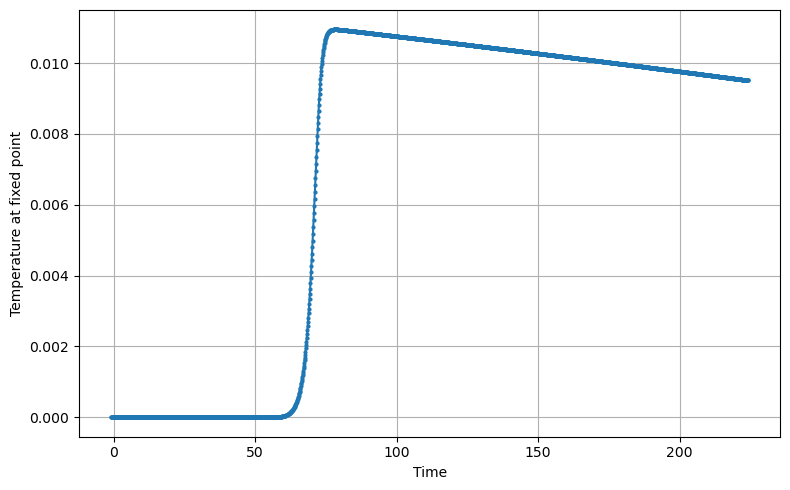

In [2]:
# Target point: equator, mid-radius, prime meridian
target_r_frac = 0.5
target_theta = np.pi / 2
target_phi = 0.0

folderpath = 'C:/Users/simon/OneDrive/Desktop/movie_test/' 
npz_files = sorted(glob.glob(folderpath+'test_*.npz'))

times = []
T_values = []

# Initialize labels
grid_r_label = None
grid_theta_label = None
grid_phi_label = None

for fname in npz_files:
    try:
        aa = np.load(fname, allow_pickle=True)

        if 'temperature' in aa.files:
            field = aa['temperature']
        else:
            print(f"'temperature' not found in Visu file")
        
#        if "temperature" not in aa.files:
#            print(f"Skipping {fname} (no temperature)")
#            continue

        Ek = aa['Ek']
        Ra = aa['Ra']
        Pr = aa['Pr']
        Pm = aa['Pm']

        #field = aa["temperature"]
        time = aa["time"].item()
        grid_r = aa["grid_r"]
        grid_theta = aa["grid_theta"]
        grid_phi = aa["grid_phi"]

        i_r = np.argmin(np.abs(grid_r - target_r_frac))
        #i_theta = np.argmin(np.abs(grid_theta - target_theta))
        i_phi = np.argmin(np.abs(grid_phi - target_phi))

        T_val = field[i_r, i_phi] #field[i_r, i_theta, i_phi]

        times.append(time)
        T_values.append(T_val)

        # Store labels for plot title
        if grid_r_label is None:
            grid_r_label = grid_r[i_r]
            #grid_theta_label = grid_theta[i_theta]
            grid_phi_label = grid_phi[i_phi]

    except Exception as e:
        print(f"Error reading {fname}: {e}")

# Convert and sort
times = np.array(times)
T_values = np.array(T_values)
sorted_idx = np.argsort(times)
times = times[sorted_idx]
T_values = T_values[sorted_idx]

# Plot safely only if data was loaded
if len(times) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(times, T_values, marker='o', markersize=2)
    plt.xlabel("Time")
    plt.ylabel("Temperature at fixed point")
    #plt.title("Temperature vs Time at (r ≈ %.2f, θ ≈ %.2f, φ ≈ %.2f)" % (
        #grid_r_label, grid_phi_label))
    plt.grid(True)
    #plt.xlim(90, 90.4)
    #plt.ylim(0.01083, 0.01087)
    
    plt.tight_layout()
    plt.show()
else:
    print("No temperature data was extracted.")

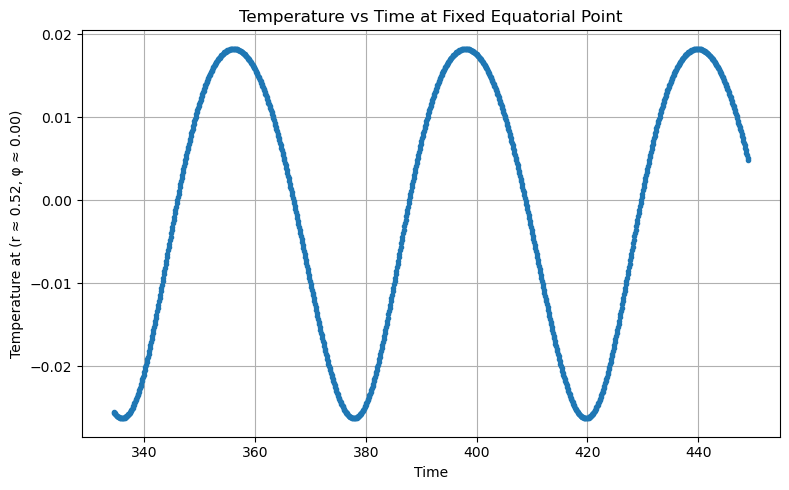

In [14]:
#Step by step determination of drift frequency

#Step 1: Extract temperature at a fixed point (r, φ) from 
#equatorial slices and build a time series of T(t)

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

folderpath = 'C:/Users/simon/OneDrive/Desktop/Ra9400/movie_test/'
npz_files = sorted(glob.glob(folderpath + 'test_*.npz'))

# Choose a point in (r, φ)
target_r_frac = 0.5     # mid-radius
target_phi = 0.0        # φ = 0

times = []
T_values = []

for fname in npz_files:
    try:
        aa = np.load(fname, allow_pickle=True)
        if "temperature" not in aa.files:
            continue

        temp = aa["temperature"]
        time = aa["time"].item()
        grid_r = aa["grid_r"]
        grid_phi = aa["grid_phi"]

        i_r = np.argmin(np.abs(grid_r - target_r_frac))
        i_phi = np.argmin(np.abs(grid_phi - target_phi))

        T_val = temp[i_r, i_phi]
        times.append(time)
        T_values.append(T_val)

    except Exception as e:
        print(f"Error reading {fname}: {e}")

# Plot T(t)
times = np.array(times)
T_values = np.array(T_values)

plt.figure(figsize=(8, 5))
plt.plot(times, T_values, marker='o', markersize=3)
plt.xlabel("Time")
plt.ylabel("Temperature at (r ≈ %.2f, φ ≈ %.2f)" % (grid_r[i_r], grid_phi[i_phi]))
plt.title("Temperature vs Time at Fixed Equatorial Point")
plt.grid(True)
plt.tight_layout()
plt.show()


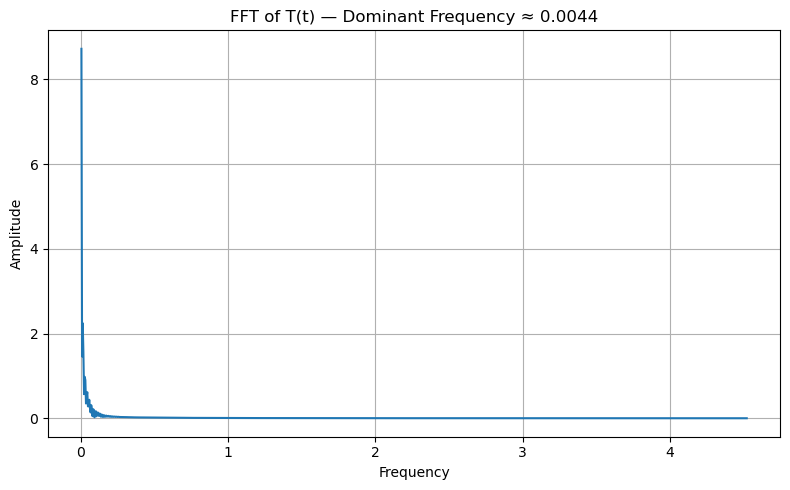

Estimated Drift Frequency: 0.0044


In [9]:
#Step 2: Compute Drift Frequency via FFT

from scipy.fft import fft, fftfreq

# Detrend (remove mean)
T_centered = T_values - np.mean(T_values)

N = len(T_centered)
dt = np.mean(np.diff(times))  # assumes roughly uniform timestep
frequencies = fftfreq(N, d=dt)
spectrum = fft(T_centered)

# Take positive frequencies only
positive_freqs = frequencies[frequencies > 0]
positive_power = np.abs(spectrum[frequencies > 0])

# Find dominant frequency
dominant_freq = positive_freqs[np.argmax(positive_power)]

plt.figure(figsize=(8, 5))
plt.plot(positive_freqs, positive_power)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title(f"FFT of T(t) — Dominant Frequency ≈ {dominant_freq:.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Estimated Drift Frequency: {dominant_freq:.4f}")


In [3]:
#Step 3: Solve for Drift frequency

Ra_sim = 93.25  # or your actual Rayleigh
f_d = dominant_freq

# Use slope 'a' from the paper (approx 0.417 from fitting)
a = 0.417
Ra_crit = Ra_sim - f_d / a

print(f"Estimated Ra where drift = 0: Ra_crit ≈ {Ra_crit:.2f}")

Estimated Ra where drift = 0: Ra_crit ≈ 93.24


Ra = 91.50, Drift frequency = 0.0533
Ra = 94.00, Drift frequency = -0.0222


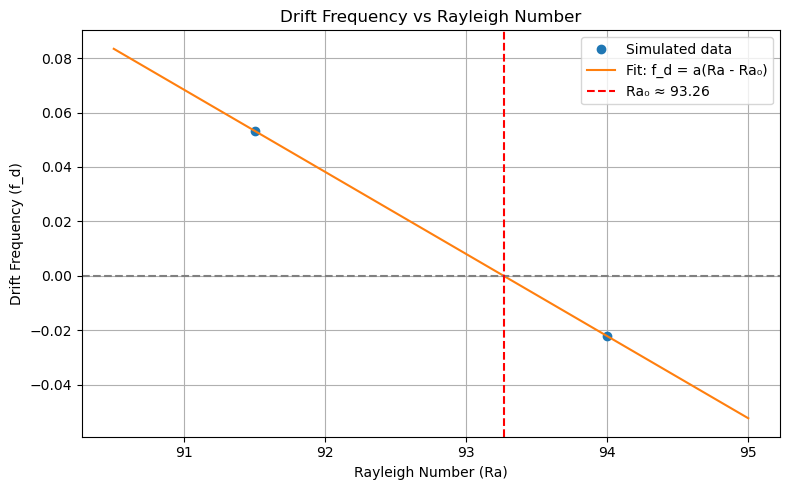


Estimated slope a ≈ -0.0302
Estimated Rayleigh where drift = 0: Ra₀ ≈ 93.2647


In [20]:
#Putting everything together using 3 different simulations

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# Define your simulations
simulations = {
    91.5: "C:/Users/simon/OneDrive/Desktop/Ra9150/movie_test/",
    #93.25: "C:/Users/simon/OneDrive/Desktop/Ra9325/movie_test/",
    #93.31: "C:/Users/simon/OneDrive/Desktop/Ra9331/movie_test/",
    94.0: "C:/Users/simon/OneDrive/Desktop/Ra9400/movie_test/",
}

# Choose a fixed point
target_r_frac = 0.5
target_phi = 0.0

Ra_list = []
fd_list = []

def extract_drift_frequency(folderpath):
    npz_files = sorted(glob.glob(folderpath + "test_*.npz"))
    times = []
    T1_values = []
    T2_values = []

    # Choose two close φ positions
    phi1 = 0.0
    phi2 = 0.2  # adjust depending on resolution

    for fname in npz_files:
        try:
            aa = np.load(fname, allow_pickle=True)
            if "temperature" not in aa.files:
                continue

            temp = aa["temperature"]
            time = aa["time"].item()
            grid_r = aa["grid_r"]
            grid_phi = aa["grid_phi"]

            i_r = np.argmin(np.abs(grid_r - 0.5))
            i_phi1 = np.argmin(np.abs(grid_phi - phi1))
            i_phi2 = np.argmin(np.abs(grid_phi - phi2))

            T1 = temp[i_r, i_phi1]
            T2 = temp[i_r, i_phi2]

            times.append(time)
            T1_values.append(T1)
            T2_values.append(T2)

        except Exception as e:
            print(f"Error reading {fname}: {e}")

    times = np.array(times)
    T1_values = np.array(T1_values)
    T2_values = np.array(T2_values)

    if len(times) < 10:
        print("Not enough data in", folderpath)
        return None

    # Compute FFT of T1
    T_centered = T1_values - np.mean(T1_values)
    dt = np.mean(np.diff(times))
    N = len(times)
    freqs = fftfreq(N, d=dt)
    spectrum = fft(T_centered)

    positive_freqs = freqs[freqs > 0]
    positive_amp = np.abs(spectrum[freqs > 0])
    f_d = positive_freqs[np.argmax(positive_amp)]

    # Detect direction with cross-correlation
    corr = np.correlate(T2_values - np.mean(T2_values),
                        T1_values - np.mean(T1_values), mode='full')
    lag = np.argmax(corr) - (len(T1_values) - 1)

    # Reverse sign if drift goes backward in φ
    if lag < 0:
        f_d = -f_d

    return f_d

# Loop over simulations
for Ra, path in simulations.items():
    f_d = extract_drift_frequency(path)
    if f_d is not None:
        Ra_list.append(Ra)
        fd_list.append(f_d)
        print(f"Ra = {Ra:.2f}, Drift frequency = {f_d:.4f}")

# Fit and plot
Ra_vals = np.array(Ra_list)
fd_vals = np.array(fd_list)

def drift_model(Ra, a, Ra0):
    return a * (Ra - Ra0)

params, _ = curve_fit(drift_model, Ra_vals, fd_vals)
a_fit, Ra0_fit = params

Ra_fit = np.linspace(min(Ra_vals) - 1, max(Ra_vals) + 1, 200)
fd_fit = drift_model(Ra_fit, a_fit, Ra0_fit)

plt.figure(figsize=(8, 5))
plt.plot(Ra_vals, fd_vals, 'o', label='Simulated data')
plt.plot(Ra_fit, fd_fit, '-', label='Fit: f_d = a(Ra - Ra₀)')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(Ra0_fit, color='red', linestyle='--', label=f"Ra₀ ≈ {Ra0_fit:.2f}")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Drift Frequency (f_d)")
plt.title("Drift Frequency vs Rayleigh Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nEstimated slope a ≈ {a_fit:.4f}")
print(f"Estimated Rayleigh where drift = 0: Ra₀ ≈ {Ra0_fit:.4f}")